<a href="https://colab.research.google.com/github/DidierAgamez/Analisis_modelo_masa_resorte/blob/main/Masa_resorte.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [82]:
"""
Imports de librerias y constantes
------------------------------------------------------------
Esta celda centraliza todas las importaciones de librerías
y define parámetros básicos (rutas y constantes).
"""

from pathlib import Path

import os                        #Operaciones con el sistema de archivos
import glob                      #Búsqueda y manejo de archivos

import cv2                       # Visión por computadora
import numpy as np               # Cálculo numérico
import math                      # Funciones matemáticas
import pandas as pd              # DataFrames y CSV
import matplotlib.pyplot as plt  # Gráficos
import json

from scipy.signal import savgol_filter, find_peaks
from scipy.optimize import least_squares
from scipy.integrate import solve_ivp

# ---------- Parámetros del proyecto ----------
# EDITA: ruta al video que vas a analizar.
VIDEO_PATH = "/content/Masa_resorte_200g.mp4"   #Ruta del video
OUT_DIR    = "frames"                  # Carpeta donde se guardan frames y resultados
EVERY      = 1                         # Guardar cada N frames (1 = todos)
MASS       = 1.0                       # Masa "m" si aplicamos modelo masa–resorte
MAX_FRAMES_ANALISIS = 800              # Límite de frames a analizar desde el inicio de movimiento

# Crear carpeta de salida si no existe
Path(OUT_DIR).mkdir(parents=True, exist_ok=True)

# ---------- Estilo de gráficos ----------
plt.rcParams["figure.figsize"] = (8, 4)
plt.rcParams["axes.grid"] = True


In [66]:
def video_report(video_path: str,
                 out_dir: str = "frames",
                 every: int = 1,
                 save_frames: bool = True) -> pd.DataFrame:
    """
    Genera un reporte de frames y tiempos del video de entrada.

    Parameters
    ----------
    video_path : str
        Ruta al archivo de video.
    out_dir : str, default 'frames'
        Carpeta de salida para imágenes y CSV.
    every : int, default 1
        Guardar 1 de cada 'every' frames.
    save_frames : bool, default True
        Si es True, guarda los frames como imágenes .jpg.

    Returns
    -------
    pd.DataFrame
        DataFrame con columnas: ['frame_id', 't_seconds', 'path'].
    """
    out = Path(out_dir)
    out.mkdir(parents=True, exist_ok=True)

    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise IOError(f"No se pudo abrir el video: {video_path}")

    fps = cap.get(cv2.CAP_PROP_FPS) or 30.0

    filas = []
    frame_id = -1
    while True:
        ok, frame = cap.read()
        if not ok:
            break
        frame_id += 1
        if frame_id % every != 0:
            continue

        t = frame_id / fps
        path = ""
        if save_frames:
            img_path = out / f"frame_{frame_id:06d}.jpg"
            cv2.imwrite(str(img_path), frame)
            path = str(img_path)

        filas.append({"frame_id": frame_id, "t_seconds": t, "path": path})

    cap.release()

    df = pd.DataFrame(filas)
    df.to_csv(out / "frames_index.csv", index=False)
    return df


# --- Ejecución de ejemplo del bloque ---
df_index = video_report(VIDEO_PATH, out_dir=OUT_DIR, every=EVERY, save_frames=True)
print(df_index.head())
print(f"Guardado: {len(df_index)} filas → {OUT_DIR}/frames_index.csv")


   frame_id  t_seconds                     path
0         0   0.000000  frames/frame_000000.jpg
1         1   0.016663  frames/frame_000001.jpg
2         2   0.033326  frames/frame_000002.jpg
3         3   0.049989  frames/frame_000003.jpg
4         4   0.066652  frames/frame_000004.jpg
Guardado: 461 filas → frames/frames_index.csv


In [68]:
"""
Detección automática del fondo, ROI e inicio de movimiento
------------------------------------------------------------

Objetivos:
1. Estimar un fondo estático combinando un subconjunto de frames.
2. Detectar automáticamente el primer instante con movimiento significativo.
3. Determinar un ROI (región de interés) alrededor del objeto en movimiento.
"""

# --- Cargar índice de frames ---
df_index = pd.read_csv("/content/frames/frames_index.csv")
print(f"Frames cargados: {len(df_index)}")

#Estimar los fondos
def estimate_background_from_frames(df, sample_step=10, max_samples=200):
    """
    Calcula el fondo estático (imagen BGR) como la mediana de varios frames.

    df : DataFrame
        Contiene la columna 'path' con rutas a los frames.
    sample_step : int
        Toma 1 de cada N frames.
    max_samples : int
        Número máximo de imágenes a promediar.
    """
    samples = []
    for i, row in enumerate(df.iloc[::sample_step].itertuples()):
        if len(samples) >= max_samples:
            break
        frame = cv2.imread(row.path)
        if frame is not None:
            samples.append(frame)
    if not samples:
        raise ValueError("No se pudieron cargar frames para estimar fondo.")
    bg = np.median(np.stack(samples, axis=0), axis=0).astype(np.uint8)
    return bg

# ============================================================
# (2) DETECTAR INICIO DE MOVIMIENTO Y ROI
# ============================================================
def auto_motion_roi_and_start_from_frames(df, bg_bgr, thresh_scale=3.0):
    """
    Analiza las diferencias respecto al fondo para determinar:
      - Primer frame con movimiento significativo.
      - ROI que encierra el objeto en movimiento.
    """
    bg_gray = cv2.cvtColor(bg_bgr, cv2.COLOR_BGR2GRAY)
    h, w = bg_gray.shape
    energy = []

    for row in df.itertuples():
        gray = cv2.cvtColor(cv2.imread(row.path), cv2.COLOR_BGR2GRAY)
        diff = cv2.absdiff(gray, bg_gray)
        diff = cv2.GaussianBlur(diff, (5, 5), 0)
        _, mask = cv2.threshold(diff, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        energy.append(np.count_nonzero(mask))

    energy = np.array(energy, dtype=float)
    pre = max(5, min(50, len(energy)//10))
    mu, sd = energy[:pre].mean(), energy[:pre].std()
    thr = mu + thresh_scale * sd

    # Primer frame con movimiento real
    above = np.where(energy > thr)[0]
    start_frame = int(above[0]) if len(above) else int(np.argmax(energy))

    # Buscar frame pico
    lo = max(0, start_frame - 3)
    hi = min(len(energy), start_frame + 4)
    peak = lo + np.argmax(energy[lo:hi])

    # Detectar contorno más grande en ese frame
    frame_peak = cv2.imread(df.iloc[peak].path)
    gray = cv2.cvtColor(frame_peak, cv2.COLOR_BGR2GRAY)
    diff = cv2.absdiff(gray, bg_gray)
    diff = cv2.GaussianBlur(diff, (5, 5), 0)
    _, mask = cv2.threshold(diff, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    cnts, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if cnts:
        c = max(cnts, key=cv2.contourArea)
        x, y, ww, hh = cv2.boundingRect(c)
        pad = 10
        x1 = max(0, x - pad)
        y1 = max(0, y - pad)
        x2 = min(w, x + ww + pad)
        y2 = min(h, y + hh + pad)
        roi = (x1, y1, x2, y2)
    else:
        roi = (w//4, h//4, 3*w//4, 3*h//4)  # fallback central

    return roi, start_frame, energy


#Ejecucion
BG = estimate_background_from_frames(df_index, sample_step=10, max_samples=200)
ROI, START, ENERGY = auto_motion_roi_and_start_from_frames(df_index, BG, thresh_scale=3.0)

print("ROI detectado:", ROI)
print("Frame de inicio de movimiento:", START)



Frames cargados: 461
ROI detectado: (0, 252, 281, 551)
Frame de inicio de movimiento: 12


In [70]:
"""
Extracción de centroides en la región de interés (ROI)
-----------------------------------------------------------------

Objetivos:
1. Procesar los frames desde el inicio de movimiento (START) hasta el final.
2. Calcular los centroides dentro del ROI para cada frame.
3. Guardar los resultados en un DataFrame y exportarlos a CSV.
"""

# --- Cargar índice de frames ---
fps = 1.0 / (df_index["t_seconds"].iloc[1] - df_index["t_seconds"].iloc[0])  # estimado por diferencia temporal

#  FUNCIÓN AUXILIAR: Cálculo del centroide dentro del ROI
def centroid_in_roi(img_bgr, roi):
    """
    Calcula el centroide del objeto principal dentro del ROI.

    Retorna:
        (cx, cy) en coordenadas absolutas del frame o None.
    """
    x1, y1, x2, y2 = roi
    sub = img_bgr[y1:y2, x1:x2]
    gray = cv2.cvtColor(sub, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Umbralización automática con Otsu
    _, mask = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Limpieza morfológica
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=1)

    # Contorno principal
    cnts, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not cnts:
        return None

    c = max(cnts, key=cv2.contourArea)
    M = cv2.moments(c)
    if M["m00"] == 0:
        return None

    cx = x1 + (M["m10"] / M["m00"])
    cy = y1 + (M["m01"] / M["m00"])
    return float(cx), float(cy)

# FUNCIÓN PRINCIPAL: Procesar frames y registrar centroides
def extract_centroids_from_frames(df, roi, start_frame, fps, max_frames=None):
    """
    Recorre los frames desde el inicio del movimiento y extrae los centroides.

    df : DataFrame con columnas ['frame_id', 't_seconds', 'path']
    roi : tuple (x1, y1, x2, y2)
    start_frame : int
    fps : float (cuadros por segundo)
    """
    filas = []
    subset = df[df["frame_id"] >= start_frame]
    if max_frames is not None:
        subset = subset.head(max_frames)

    for row in subset.itertuples():
        frame = cv2.imread(row.path)
        if frame is None:
            continue
        centro = centroid_in_roi(frame, roi)
        if centro is not None:
            filas.append({
                "frame_id": row.frame_id,
                "t_seconds": row.t_seconds,
                "x": centro[0],
                "y": centro[1]
            })

    return pd.DataFrame(filas)

# EJECUCIÓN DEL BLOQUE
df_centroids = extract_centroids_from_frames(
    df_index,
    roi=ROI,
    start_frame=START,
    fps=fps,
    max_frames=None  # o por ejemplo 300
)

print(df_centroids.head())
print(f"Total de centroides detectados: {len(df_centroids)}")

# Guardar resultados
out_csv = Path("frames/centroids.csv")
df_centroids.to_csv(out_csv, index=False)
print(f"Archivo guardado: {out_csv}")


   frame_id  t_seconds           x           y
0        12   0.199957  142.757133  383.151589
1        13   0.216620  142.755415  383.002871
2        14   0.233283  142.756975  382.888024
3        15   0.249946  142.783846  382.827851
4        16   0.266609  142.879484  382.790242
Total de centroides detectados: 449
Archivo guardado: frames/centroids.csv


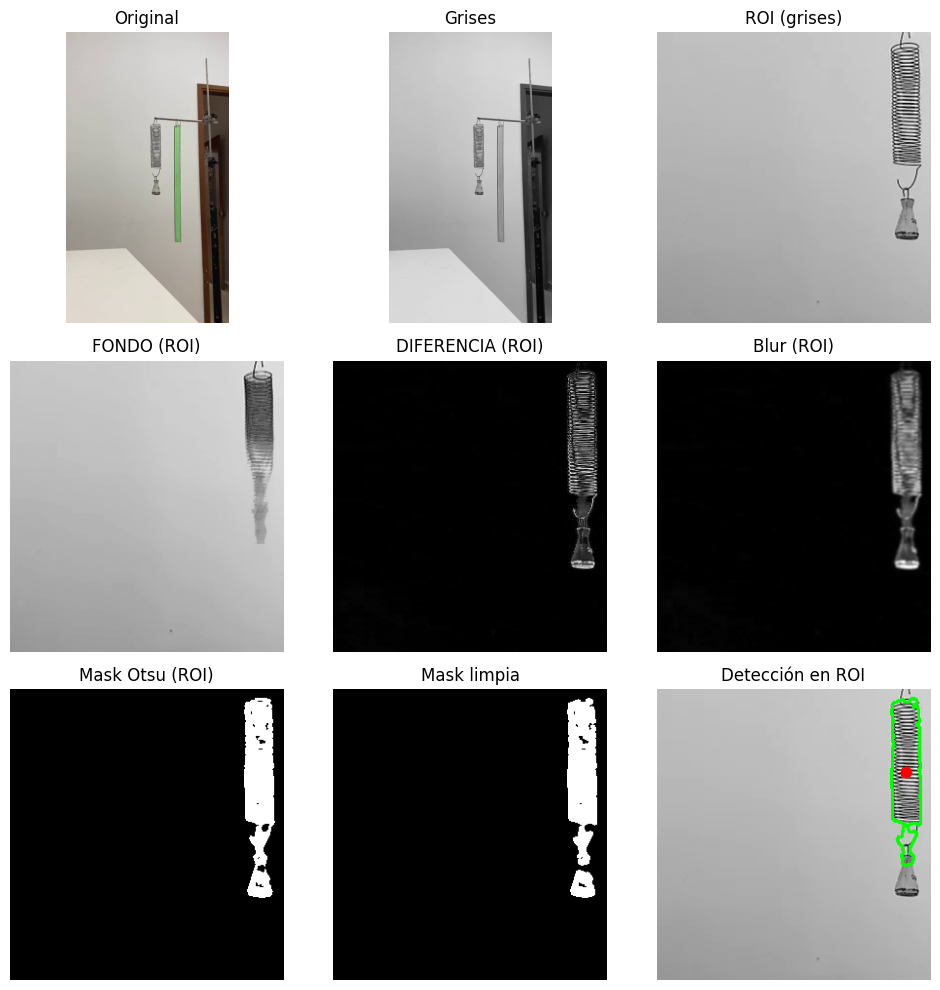

Centroide detectado en frame diagnóstico: (255.18369152970922, 337.94698693636747)


In [71]:
"""
Visualización de la preparación de los frames
---------------------------------------------------------------
Objetivo:
  Mostrar cómo evoluciona un frame a través de cada transformación
  aplicada dentro del ROI hasta detectar el centroide.

Transformaciones mostradas:
  1) Original (RGB)
  2) Grises (completo)
  3) ROI (grises)
  4) Fondo (ROI)
  5) Diferencia |frame - fondo| (ROI)
  6) Blur Gaussiano (ROI)
  7) Máscara Otsu (ROI)
  8) Máscara limpia (morfología)
  9) Detección en ROI (contorno y centroide)

Entradas:
  - frame_bgr: imagen BGR del frame actual.
  - roi: tupla (x1, y1, x2, y2).
  - bg_gray: fondo en escala de grises.

Salida:
  - (cx, cy) si se detecta el centroide; None si no hay detección.
  - Muestra figura con 9 subplots.
"""


def visualizar_pipeline_en_frame(frame_bgr, roi, bg_gray):
    x1, y1, x2, y2 = roi

    # --- Paso 1: Imágenes base ---
    frame_rgb  = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)
    gray_full  = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2GRAY)

    roi_gray   = gray_full[y1:y2, x1:x2]
    bg_roi     = bg_gray[y1:y2, x1:x2]

    # --- Paso 2: Procesamiento ---
    diff_roi   = cv2.absdiff(roi_gray, bg_roi)
    blur_roi   = cv2.GaussianBlur(diff_roi, (5, 5), 0)
    _, mask    = cv2.threshold(blur_roi, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    kernel     = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    mask_clean = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=1)

    # --- Paso 3: Detección de contorno y centroide ---
    cnts, _ = cv2.findContours(mask_clean, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cxcy = None
    roi_vis = cv2.cvtColor(roi_gray, cv2.COLOR_GRAY2BGR)

    if cnts:
        c = max(cnts, key=cv2.contourArea)
        M = cv2.moments(c)
        if M["m00"] != 0:
            cx = x1 + (M["m10"] / M["m00"])
            cy = y1 + (M["m01"] / M["m00"])
            cxcy = (float(cx), float(cy))
            cv2.drawContours(roi_vis, [c], -1, (0, 255, 0), 2)
            cv2.circle(roi_vis, (int(round(cx - x1)), int(round(cy - y1))), 6, (0, 0, 255), -1)

    # --- Paso 4: Visualización 3x3 ---
    fig, axes = plt.subplots(3, 3, figsize=(10, 10))
    axes = axes.ravel()

    axes[0].imshow(frame_rgb);              axes[0].set_title("Original");             axes[0].axis("off")
    axes[1].imshow(gray_full, cmap="gray"); axes[1].set_title("Grises");               axes[1].axis("off")
    axes[2].imshow(roi_gray, cmap="gray");  axes[2].set_title("ROI (grises)");         axes[2].axis("off")

    axes[3].imshow(bg_roi, cmap="gray");    axes[3].set_title("FONDO (ROI)");          axes[3].axis("off")
    axes[4].imshow(diff_roi, cmap="gray");  axes[4].set_title("DIFERENCIA (ROI)");     axes[4].axis("off")
    axes[5].imshow(blur_roi, cmap="gray");  axes[5].set_title("Blur (ROI)");           axes[5].axis("off")

    axes[6].imshow(mask, cmap="gray");      axes[6].set_title("Mask Otsu (ROI)");      axes[6].axis("off")
    axes[7].imshow(mask_clean, cmap="gray");axes[7].set_title("Mask limpia");          axes[7].axis("off")
    axes[8].imshow(roi_vis[:, :, ::-1]);    axes[8].set_title("Detección en ROI");     axes[8].axis("off")

    plt.tight_layout()
    plt.show()

    return cxcy



# (Ejecución del bloque)

# Índice del frame a inspeccionar
idx_vis = 60  #Este valor corresponde al indice del frame a mostrar (se puede modificar)

# Cargar frame y fondo
frame_path = df_index.loc[df_index["frame_id"] == idx_vis, "path"].values[0]
frame_dbg = cv2.imread(frame_path)
bg_gray_vis = cv2.cvtColor(BG, cv2.COLOR_BGR2GRAY)

# Visualizar pipeline
cxcy_dbg = visualizar_pipeline_en_frame(frame_dbg, ROI, bg_gray_vis)
print("Centroide detectado en frame diagnóstico:", cxcy_dbg)



[OK] Trayectoria cargada: 449 muestras


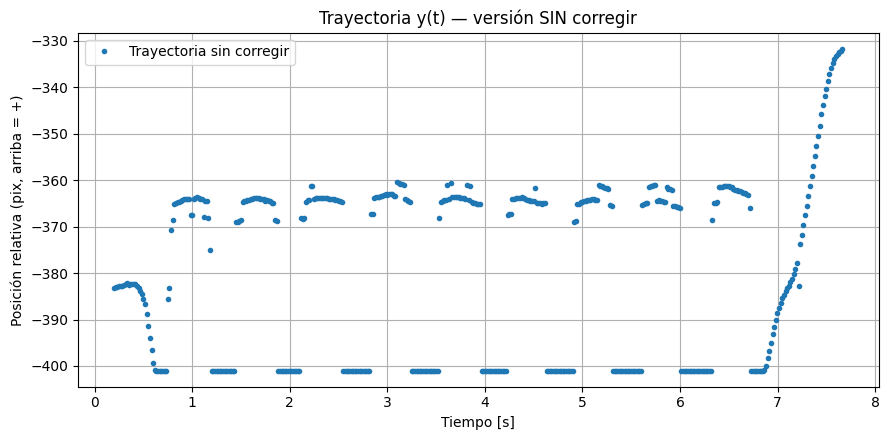

[OK] Señal preparada con 449 puntos.


In [73]:
"""
Preparación de señales para ajuste de parámetros
------------------------------------------------------------
Objetivo:
  - Cargar la trayectoria detectada (centroides)
  - Construir la señal y(t) aplicando la convención física:
      * En imagen: y crece hacia ABAJO.
      * En física: preferimos y positiva hacia ARRIBA.
        → Por ello, y = -y_pix.
  - Visualizar la trayectoria y(t) para inspección inicial.

Entradas:
  - frames/centroids.csv

Salidas:
  - t_raw   : vector de tiempo (segundos)
  - y_raw   : vector de posición (pix, arriba = positivo)
  - df_raw  : DataFrame completo de trayectoria
  - Gráfico diagnóstico de y(t)
"""


# Cargar la trayectoria detectada

centroids_path = Path("frames/centroids.csv")

if not centroids_path.exists():
    raise FileNotFoundError("No se encontró el archivo frames/centroids.csv. Ejecuta primero el Bloque 4.")

df_raw = pd.read_csv(centroids_path)
print(f"[OK] Trayectoria cargada: {len(df_raw)} muestras")


# Construcción de la señal y(t)

t_raw   = df_raw["t_seconds"].to_numpy()
y_raw_p = df_raw["y"].to_numpy()
y_raw   = -y_raw_p   # invertir eje vertical: hacia arriba es positivo


#  Visualización inicial de la trayectoria

plt.figure(figsize=(9, 4.5))
plt.plot(t_raw, y_raw, ".", lw=1, color="tab:blue", label="Trayectoria sin corregir")
plt.xlabel("Tiempo [s]")
plt.ylabel("Posición relativa (pix, arriba = +)")
plt.title("Trayectoria y(t) — versión SIN corregir")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"[OK] Señal preparada con {len(t_raw)} puntos.")



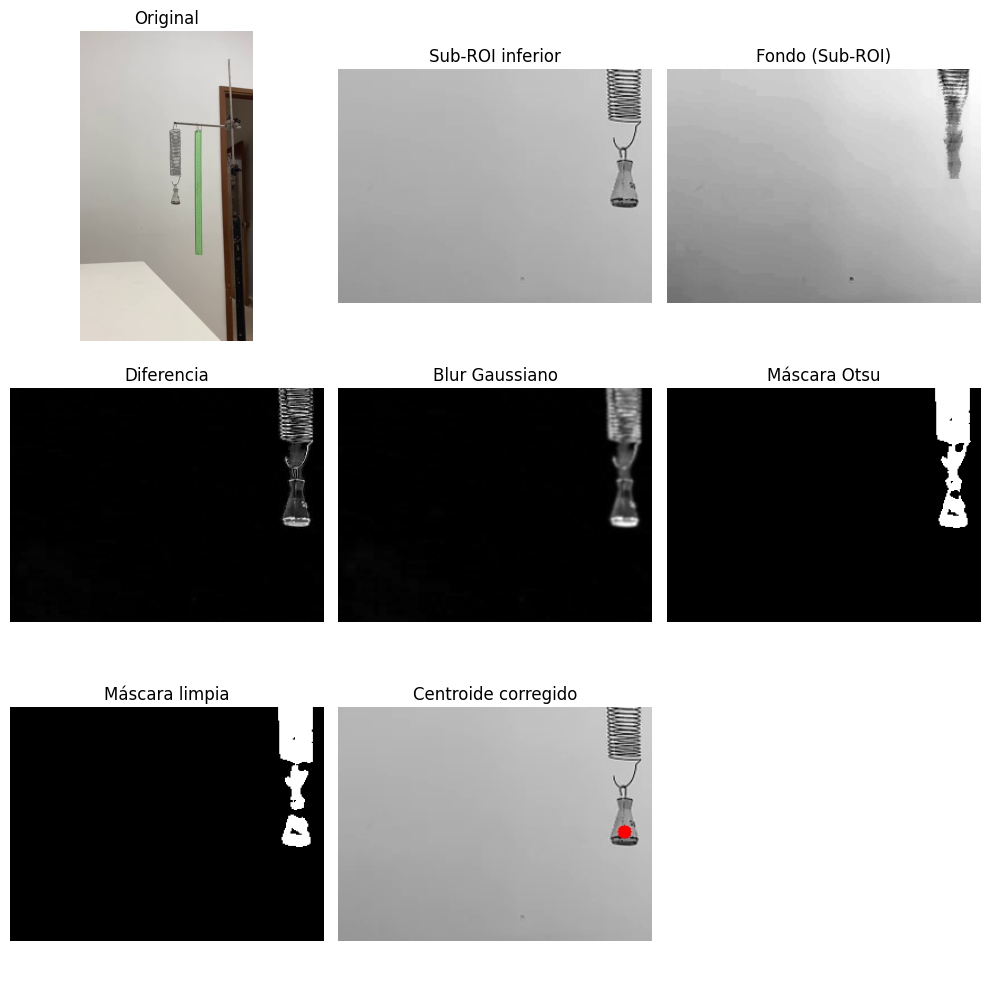

Centroide corregido en frame 60: (255.8307240704501, 453.0446836268754)
Centroide corregido en frame diagnóstico: (255.8307240704501, 453.0446836268754)


In [74]:
"""
Corrección de centroides (foco en la masa)
------------------------------------------------------------
Objetivo:
  Corregir la detección del centroide para centrarse en la MASA
  colgante del sistema, evitando detecciones en la mano o resorte.

Estrategia combinada:
  A) Analizar solo la franja inferior del ROI (para descartar la mano).
  B) Filtrar contornos por área, circularidad y relación de aspecto.
  C) Favorecer centroide más bajo y continuidad temporal.
  D) Visualizar paso a paso el proceso sobre un frame específico.

Entradas:
  - frames/frames_index.csv  → lista de frames
  - BG (imagen del fondo)
  - ROI (definida previamente)
  - idx_vis (frame a inspeccionar)

Salidas:
  - centroid_mass_corrected(): (cx, cy)
  - extract_corrected_centroids_from_frames(): DataFrame con trayectorias corregidas
  - visualizar_correccion_en_frame(): figura 3x3 del pipeline
"""


# (1) Funciones auxiliares


def _circularidad(area, perimetro):
    if perimetro <= 1e-6:
        return 0.0
    return float(4.0 * math.pi * area / (perimetro ** 2))

def _aspect_ratio(cnt):
    x, y, w, h = cv2.boundingRect(cnt)
    if h == 0:
        return 999.0
    r = w / float(h)
    return float(max(r, 1.0 / r))  # ~1 si es redondo


#  Detección de la masa en un frame


def centroid_mass_corrected(img_bgr, roi, bg_gray,
                            lower_frac=0.55,
                            min_area=150, max_area=4000,
                            w_y=2.5, w_circ=3.0, w_aspect=2.0, w_dist=0.5,
                            prev_cxcy=None):
    """
    Detecta el centroide de la MASA en un frame.
    """
    x1, y1, x2, y2 = roi
    H = y2 - y1
    yb1 = y1 + int((1.0 - lower_frac) * H)
    yb2 = y2

    sub = img_bgr[yb1:yb2, x1:x2]
    bg_sub = bg_gray[yb1:yb2, x1:x2]
    gray_sub = cv2.cvtColor(sub, cv2.COLOR_BGR2GRAY)

    # Diferencia con mejora de contraste
    diff = cv2.absdiff(gray_sub, bg_sub)
    diff = cv2.convertScaleAbs(diff, alpha=2.0, beta=0)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    diff_eq = clahe.apply(diff)
    blur = cv2.GaussianBlur(diff_eq, (3, 3), 0)
    _, mask = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    white_ratio = np.sum(mask > 0) / mask.size
    if white_ratio < 0.005:
        mask = cv2.adaptiveThreshold(
            blur, 255,
            cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,
            11, 2
        )

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    mask_clean = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=1)

    cnts, _ = cv2.findContours(mask_clean, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not cnts:
        return None

    h_sub, w_sub = mask_clean.shape[:2]
    y_norm = float(h_sub) + 1e-6
    best_score = -1e9
    best = None

    for c in cnts:
        area = cv2.contourArea(c)
        if area < min_area or area > max_area:
            continue
        per = cv2.arcLength(c, True)
        circ = _circularidad(area, per)
        aspect = _aspect_ratio(c)
        M = cv2.moments(c)
        if M["m00"] == 0:
            continue
        cx_loc = M["m10"] / M["m00"]
        cy_loc = M["m01"] / M["m00"]

        cx_abs = x1 + cx_loc
        cy_abs = yb1 + cy_loc

        term_y = (cy_loc / y_norm) * w_y
        term_c = circ * w_circ
        term_a = (2.0 - aspect) * w_aspect
        term_d = 0.0
        if prev_cxcy is not None:
            dx = cx_abs - prev_cxcy[0]
            dy = cy_abs - prev_cxcy[1]
            dist = math.hypot(dx, dy)
            term_d = (-dist / max(w_sub, h_sub)) * w_dist

        score = term_y + term_c + term_a + term_d
        if score > best_score:
            best_score = score
            best = (cx_abs, cy_abs)

    return best



#  Extracción de centroides corregidos (desde frames)


def extract_corrected_centroids_from_frames(df_index, roi, bg_bgr,
                                            out_csv_path,
                                            start_frame=0,
                                            lower_frac=0.6,
                                            min_area=150, max_area=4000,
                                            max_frames=None):
    """
    Recorre los frames y aplica la corrección de masa.
    """
    bg_gray = cv2.cvtColor(bg_bgr, cv2.COLOR_BGR2GRAY)
    filas, prev = [], None
    subset = df_index[df_index["frame_id"] >= start_frame]
    if max_frames is not None:
        subset = subset.head(max_frames)

    for row in subset.itertuples():
        frame = cv2.imread(row.path)
        if frame is None:
            continue
        cxy = centroid_mass_corrected(frame, roi, bg_gray,
                                      lower_frac=lower_frac,
                                      min_area=min_area,
                                      max_area=max_area,
                                      prev_cxcy=prev)
        if cxy is not None:
            filas.append({
                "frame_id": row.frame_id,
                "t_seconds": row.t_seconds,
                "x": cxy[0],
                "y": cxy[1],
            })
            prev = cxy

    df = pd.DataFrame(filas)
    Path(out_csv_path).parent.mkdir(parents=True, exist_ok=True)
    df.to_csv(out_csv_path, index=False)
    return df



#  Visualización diagnóstica en un frame específico


def visualizar_correccion_en_frame(df_index, idx_vis, roi, bg_bgr,
                                   lower_frac=0.6,
                                   min_area=150, max_area=4000):
    """
    Visualiza el proceso de corrección paso a paso en un frame (idx_vis).
    """
    bg_gray = cv2.cvtColor(bg_bgr, cv2.COLOR_BGR2GRAY)
    frame_path = df_index.loc[df_index["frame_id"] == idx_vis, "path"].values[0]
    frame_bgr = cv2.imread(frame_path)
    if frame_bgr is None:
        raise IOError(f"No se pudo cargar el frame {idx_vis}")

    x1, y1, x2, y2 = roi
    H = y2 - y1
    yb1 = y1 + int((1.0 - lower_frac) * H)
    yb2 = y2

    sub = cv2.cvtColor(frame_bgr[yb1:yb2, x1:x2], cv2.COLOR_BGR2GRAY)
    bg_sub = bg_gray[yb1:yb2, x1:x2]
    diff = cv2.absdiff(sub, bg_sub)
    blur = cv2.GaussianBlur(diff, (5, 5), 0)
    _, mask = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    mask_clean = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=1)
    cnts, _ = cv2.findContours(mask_clean, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    roi_vis = cv2.cvtColor(sub, cv2.COLOR_GRAY2BGR)
    cxcy = centroid_mass_corrected(frame_bgr, roi, bg_gray,
                                   lower_frac=lower_frac,
                                   min_area=min_area, max_area=max_area)

    if cxcy is not None:
        cv2.circle(roi_vis,
                   (int(round(cxcy[0] - x1)), int(round(cxcy[1] - yb1))),
                   6, (0, 0, 255), -1)

    fig, axes = plt.subplots(3, 3, figsize=(10, 10))
    axes = axes.ravel()
    axes[0].imshow(cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)); axes[0].set_title("Original"); axes[0].axis("off")
    axes[1].imshow(sub, cmap="gray");        axes[1].set_title("Sub-ROI inferior");  axes[1].axis("off")
    axes[2].imshow(bg_sub, cmap="gray");     axes[2].set_title("Fondo (Sub-ROI)");   axes[2].axis("off")
    axes[3].imshow(diff, cmap="gray");       axes[3].set_title("Diferencia");        axes[3].axis("off")
    axes[4].imshow(blur, cmap="gray");       axes[4].set_title("Blur Gaussiano");    axes[4].axis("off")
    axes[5].imshow(mask, cmap="gray");       axes[5].set_title("Máscara Otsu");      axes[5].axis("off")
    axes[6].imshow(mask_clean, cmap="gray"); axes[6].set_title("Máscara limpia");    axes[6].axis("off")
    axes[7].imshow(roi_vis[:, :, ::-1]);     axes[7].set_title("Centroide corregido"); axes[7].axis("off")
    axes[8].axis("off")
    plt.tight_layout(); plt.show()

    print(f"Centroide corregido en frame {idx_vis}: {cxcy}")
    return cxcy



#  Ejecución del bloque (ejemplo)



idx_vis = 60  # Frame que se desea inspeccionar
cxcy_dbg = visualizar_correccion_en_frame(df_index, idx_vis, ROI, BG,
                                          lower_frac=0.7,
                                          min_area=200, max_area=4000)
print("Centroide corregido en frame diagnóstico:", cxcy_dbg)


In [75]:
"""
Extraemos los centroides corregidos y los guardamos en un nuevo dataframe
"""
out_csv_corr = Path(OUT_DIR) / "centroids_corrected.csv"
df_corr = extract_corrected_centroids_from_frames(
    df_index,
    ROI,
    BG,
    out_csv_path=out_csv_corr,
    start_frame=START,
    lower_frac=0.6,       # usar franja inferior del ROI
    min_area=150,
    max_area=4000,
    max_frames=None       # o define un número para acotar el análisis
)

print(df_corr.head())
print(f"Guardado CSV corregido: {out_csv_corr}")
print(f"Centroides corregidos: {len(df_corr)}")


   frame_id  t_seconds           x           y
0        13   0.216620  253.755797  380.812319
1        20   0.333261  251.180579  452.377626
2        21   0.349924  251.433679  449.578431
3        22   0.366587  252.041191  447.344106
4        23   0.383250  252.511236  443.435705
Guardado CSV corregido: frames/centroids_corrected.csv
Centroides corregidos: 429


[OK] Trayectoria corregida cargada: 429 muestras


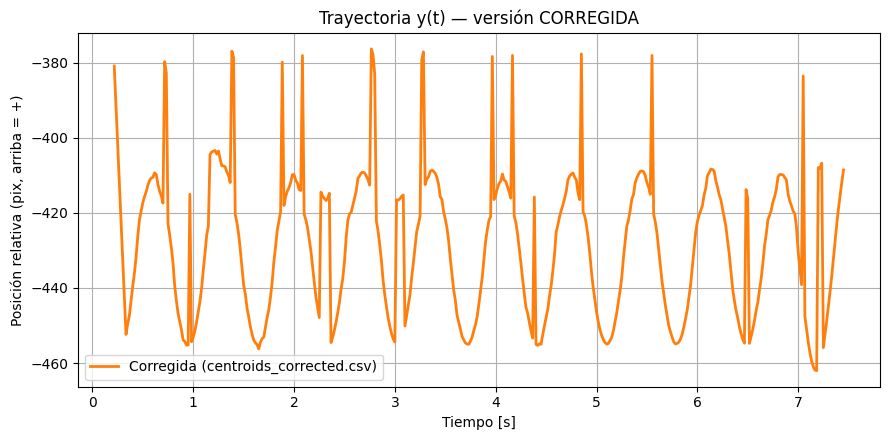

[OK] Señal corregida: 429 muestras | Archivo: centroids_corrected.csv


In [76]:
"""
Visualización de señales (CORREGIDA)
------------------------------------------------------------
Objetivo:
  - Cargar la trayectoria corregida (centroides ajustados a la masa).
  - Aplicar la convención física y = -y_pix (hacia arriba positivo).
  - Graficar la señal corregida y(t) para ver su comportamiento temporal.

Entradas:
  - frames/centroids_corrected.csv  → Trayectoria corregida

Salidas:
  - Variables: t_fix, y_fix, df_fix
  - Gráfico de y(t) corregida
"""



# Verificar archivo disponible

fix_csv = Path("frames/centroids_corrected.csv")
if not fix_csv.exists():
    alt_csv = Path("frames/centroids_mass_auto.csv")
    if alt_csv.exists():
        fix_csv = alt_csv
    else:
        raise FileNotFoundError("No se encontró ningún CSV corregido en 'frames/'.")


# Cargar datos corregidos

df_fix = pd.read_csv(fix_csv)
print(f"[OK] Trayectoria corregida cargada: {len(df_fix)} muestras")


# Construcción de la señal (convención física: y hacia ARRIBA)

t_fix   = df_fix["t_seconds"].to_numpy()
y_fix_p = df_fix["y"].to_numpy()
y_fix   = -y_fix_p  # invertir: arriba es positivo


# Visualización

plt.figure(figsize=(9, 4.5))
plt.plot(t_fix, y_fix, "-", lw=2, color="tab:orange", label=f"Corregida ({fix_csv.name})")
plt.xlabel("Tiempo [s]")
plt.ylabel("Posición relativa (pix, arriba = +)")
plt.title("Trayectoria y(t) — versión CORREGIDA")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"[OK] Señal corregida: {len(t_fix)} muestras | Archivo: {fix_csv.name}")




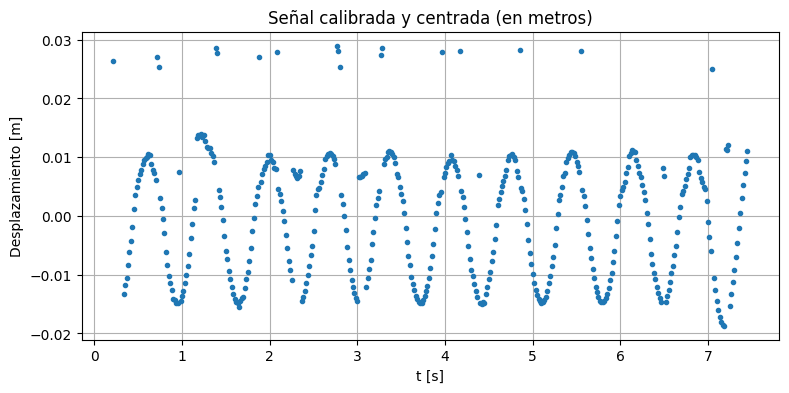

[OK] Señal calibrada: 429 muestras | Escala: 5.556e-04 m/px


In [113]:
"""
PREPARACIÓN FINAL DE LA SEÑAL
------------------------------------------------------------
Objetivo:
  - Convertir coordenadas de píxeles a metros.
  - Centrar la oscilación alrededor del equilibrio (y = 0).
  - Dejar lista la señal calibrada para los métodos A–C.

Entradas:
  - df_fix : trayectoria corregida.
  - Escala: relación px → m obtenida por medición.

Salidas:
  - Variables: t, y_m (tiempo [s], desplazamiento [m]).
"""

# Parámetros físicos conocidos
MASS = 0.2  # masa en kg (200 g)
px_per_cm = 18
px_per_m = px_per_cm * 100
scale = 1 / px_per_m  # metros por pixel

# Conversión de píxeles a metros
t_m = df_fix["t_seconds"].to_numpy()
y_px = -df_fix["y"].to_numpy()  # hacia arriba positivo
y_m = (y_px - np.mean(y_px)) * scale

plt.figure(figsize=(9, 4))
plt.plot(t_m, y_m, ".", lw=1)
plt.xlabel("t [s]")
plt.ylabel("Desplazamiento [m]")
plt.title("Señal calibrada y centrada (en metros)")
plt.grid(True)
plt.show()

print(f"[OK] Señal calibrada: {len(y_m)} muestras | Escala: {scale:.3e} m/px")



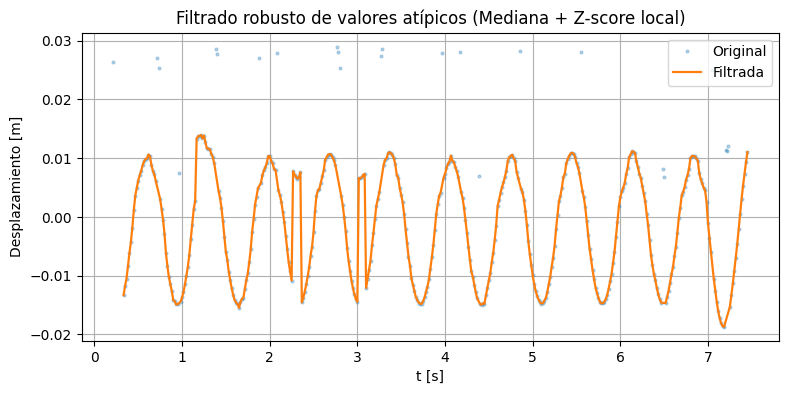

Señal filtrada: 24 valores atípicos eliminados sobre 429 muestras.


In [136]:
"""
FILTRADO ROBUSTO DE OUTLIERS EN SEÑAL OSCILATORIA
------------------------------------------------------------
Objetivo:
  - Eliminar valores atípicos espurios que no pertenecen a la
    dinámica real del sistema (saltos o picos aislados).
  - Preservar la forma oscilatoria original.

Estrategia:
  1. Suavizar la señal con un filtro de mediana.
  2. Calcular la desviación entre señal y suavizado.
  3. Reemplazar puntos que superen un umbral basado en z-score.
  4. Interpolar para mantener continuidad.

Entradas:
  - t_m, y_m : señal calibrada y centrada [s], [m]

Salidas:
  - y_m_clean : señal filtrada (sin picos atípicos)
"""

from scipy.signal import medfilt

# --- Suavizado previo (mediana) ---
y_med = medfilt(y_m, kernel_size=7)

# --- Desviación y umbral dinámico ---
residual = y_m - y_med
sigma = np.std(residual)
threshold = 2.5 * sigma  # puedes ajustar a 2.0 o 3.0 según el caso

# --- Detección de outliers ---
mask = np.abs(residual) < threshold
y_m_clean = y_m.copy()
y_m_clean[~mask] = np.nan

# --- Interpolación lineal para reemplazar outliers ---
y_m_clean = pd.Series(y_m_clean).interpolate(method="linear").to_numpy()

# --- Visualización ---
plt.figure(figsize=(9, 4))
plt.plot(t_m, y_m, ".", alpha=0.3, label="Original", markersize=4)
plt.plot(t_m, y_m_clean, "-", lw=1.6, label="Filtrada", color="tab:orange")
plt.xlabel("t [s]")
plt.ylabel("Desplazamiento [m]")
plt.title("Filtrado robusto de valores atípicos (Mediana + Z-score local)")
plt.legend(); plt.grid(True)
plt.show()

print(f"Señal filtrada: {np.sum(~mask)} valores atípicos eliminados sobre {len(y_m)} muestras.")


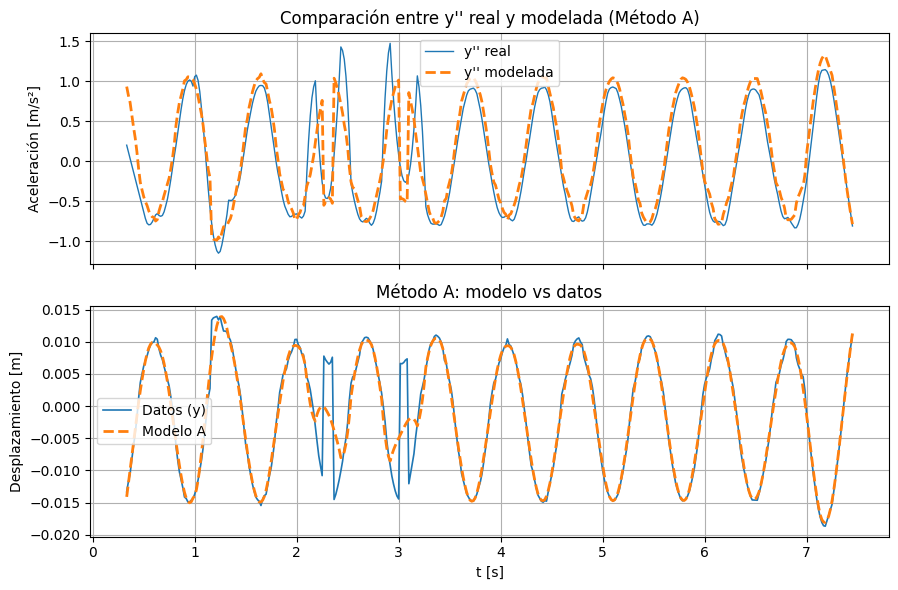

[OK] Método A :
    k = 1.4129e+01 N/m
    b = 1.5163e-02 N·s/m
    MSE(y'') = 6.9281e-02


In [137]:
"""
MÉTODO A — REGRESIÓN EN DERIVADAS (ROBUSTO)
------------------------------------------------------------
Modelo: m·y'' + b·y' + k·y = 0

Objetivo:
  - Estimar las constantes k y b a partir de la señal filtrada y_m_clean.
  - Utilizar derivadas suavizadas mediante filtro Savitzky–Golay.
  - Evitar problemas numéricos (SVD no converge) con regularización.

Entradas:
  - t_m        : tiempo [s]
  - y_m_clean  : desplazamiento [m] (filtrado)
  - m          : masa [kg]

Salidas:
  - k_hat, b_hat, mse_ydd
  - Gráficas de comparación: y'' real vs modelada y y vs modelo.
"""

from scipy.signal import savgol_filter

def fit_mass_spring_derivative(t, y, m):
    # --- Limpieza de datos ---
    t = np.asarray(t, float)
    y = np.asarray(y, float)
    valid = np.isfinite(y)
    t, y = t[valid], y[valid]

    dt = np.median(np.diff(t))
    if len(y) < 15:
        raise ValueError("La señal es demasiado corta para estimar derivadas.")

    # --- Derivadas Savitzky–Golay ---
    wl = max(7, (len(y)//20) | 1)
    y_s  = savgol_filter(y, window_length=wl, polyorder=3, deriv=0, delta=dt)
    yd   = savgol_filter(y, window_length=wl, polyorder=3, deriv=1, delta=dt)
    ydd  = savgol_filter(y, window_length=wl, polyorder=3, deriv=2, delta=dt)

    # --- Centrado para mejorar la condición numérica ---
    y_c = y_s - np.mean(y_s)
    yd_c = yd - np.mean(yd)
    ydd_c = ydd - np.mean(ydd)

    # --- Sistema de ecuaciones ---
    A = np.column_stack([yd_c, y_c])
    rhs = -m * ydd_c

    # Regularización para estabilidad numérica
    reg = 1e-6 * np.eye(A.shape[1])
    theta = np.linalg.lstsq(A.T @ A + reg, A.T @ rhs, rcond=None)[0]
    b_hat, k_hat = float(theta[0]), float(theta[1])

    # --- Error cuadrático medio ---
    ydd_hat = -(b_hat/m)*yd - (k_hat/m)*y
    mse = np.mean((ydd - ydd_hat)**2)

    # --- Gráficas de diagnóstico ---
    fig, axes = plt.subplots(2, 1, figsize=(9, 6), sharex=True)

    # Comparación de aceleraciones
    axes[0].plot(t, ydd, label="y'' real", lw=1)
    axes[0].plot(t, ydd_hat, "--", label="y'' modelada", lw=2, color="tab:orange")
    axes[0].set_ylabel("Aceleración [m/s²]")
    axes[0].set_title("Comparación entre y'' real y modelada (Método A)")
    axes[0].legend(); axes[0].grid(True)

    # Reconstrucción de la señal (modelo lineal)
    y_model = np.mean(y) + (y_s - np.mean(y_s))  # centrada para comparación
    axes[1].plot(t, y, label="Datos (y)", lw=1.2)
    axes[1].plot(t, y_model, "--", lw=2, label="Modelo A", color="tab:orange")
    axes[1].set_xlabel("t [s]")
    axes[1].set_ylabel("Desplazamiento [m]")
    axes[1].set_title("Método A: modelo vs datos")
    axes[1].legend(); axes[1].grid(True)

    plt.tight_layout()
    plt.show()

    # --- Retornar estimaciones ---
    return {"k": k_hat, "b": b_hat, "m": float(m), "mse_ydd": float(mse)}


# === Ejecución ===
est_M1 = fit_mass_spring_derivative(t_m, y_m_clean, m=MASS)
print(f"[OK] Método A :")
print(f"    k = {est_M1['k']:.4e} N/m")
print(f"    b = {est_M1['b']:.4e} N·s/m")
print(f"    MSE(y'') = {est_M1['mse_ydd']:.4e}")


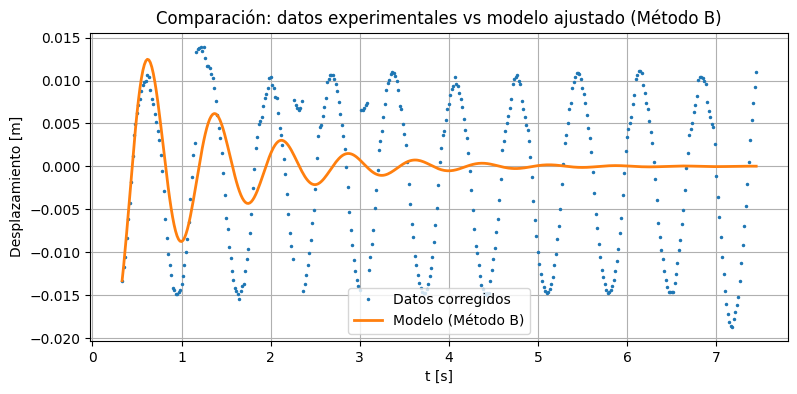

 Método B :
    k = 1.4193e+01 N/m
    b = 3.7595e-01 N·s/m
    R² = 0.0858


In [138]:
"""
MÉTODO B — AJUSTE MEDIANTE ECUACIÓN DIFERENCIAL (ROBUSTO)
------------------------------------------------------------
Modelo:  m·y'' + b·y' + k·y = 0
Objetivo:
  - Encontrar k y b minimizando el error entre y(t) medido y
    la simulación del modelo ODE.
  - Evitar errores de NaN en y0 o v0.
"""


def _simulate_mass_spring(t, y0, v0, m, k, b):
    """Simula el sistema masa-resorte amortiguado."""
    def ode(t, Y):
        y, v = Y
        dydt = v
        dvdt = -(b/m)*v - (k/m)*y
        return [dydt, dvdt]
    sol = solve_ivp(ode, [t[0], t[-1]], [y0, v0], t_eval=t, method="RK45")
    return sol.y[0]

def fit_mass_spring_ode(t, y, m, k0=None, b0=None):
    # --- Limpieza de datos ---
    t = np.asarray(t, float)
    y = np.asarray(y, float)
    valid = np.isfinite(y)
    t, y = t[valid], y[valid]

    # --- Condiciones iniciales ---
    y0 = float(y[0])
    dt = np.median(np.diff(t))
    v0 = float(np.gradient(y, dt)[0])

    # Evitar NaN o infinitos
    if not np.isfinite(y0) or not np.isfinite(v0):
        raise ValueError("Las condiciones iniciales no son finitas (y0 o v0).")

    # --- Valores iniciales de búsqueda ---
    k0 = k0 if np.isfinite(k0) else 1.0
    b0 = b0 if np.isfinite(b0) else 0.01

    def loss(params):
        k, b = params
        y_sim = _simulate_mass_spring(t, y0, v0, m, k, b)
        return np.mean((y - y_sim)**2)

    res = minimize(loss, x0=[k0, b0], bounds=[(1e-6, None), (0, None)])
    k_fit, b_fit = res.x

    # --- Evaluación final ---
    y_fit = _simulate_mass_spring(t, y0, v0, m, k_fit, b_fit)
    ss_res = np.sum((y - y_fit)**2)
    ss_tot = np.sum((y - np.mean(y))**2)
    r2 = 1 - ss_res / ss_tot

    # --- Gráfico de comparación ---
    plt.figure(figsize=(9,4))
    plt.plot(t, y, ".", ms=3, label="Datos corregidos")
    plt.plot(t, y_fit, "-", lw=2, label="Modelo (Método B)", color="tab:orange")
    plt.xlabel("t [s]")
    plt.ylabel("Desplazamiento [m]")
    plt.title("Comparación: datos experimentales vs modelo ajustado (Método B)")
    plt.legend()
    plt.grid(True)
    plt.show()

    return {"k": float(k_fit), "b": float(b_fit), "m": float(m), "r2": float(r2)}


# === Ejecución ===
est_M2 = fit_mass_spring_ode(
    t_m, y_m_clean, m=MASS,
    k0=est_M1["k"], b0=est_M1["b"]
)
print(f" Método B :")
print(f"    k = {est_M2['k']:.4e} N/m")
print(f"    b = {est_M2['b']:.4e} N·s/m")
print(f"    R² = {est_M2['r2']:.4f}")


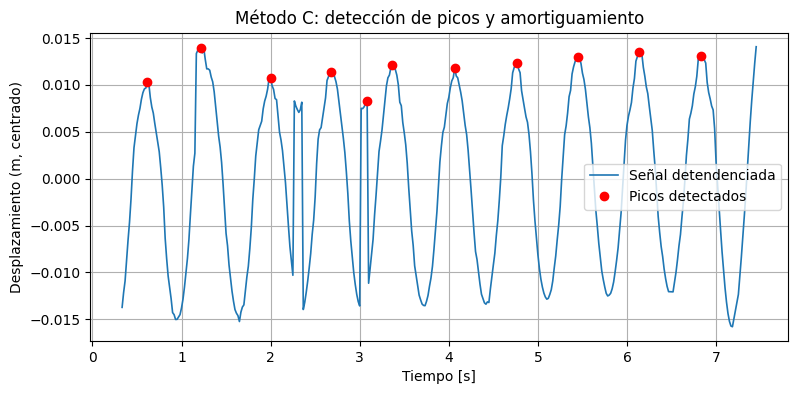

Método C (decremento logarítmico):
    δ = -0.04253
    ζ = -0.006768
    T = 0.6832 s
    ω_d = 9.197 rad/s


In [139]:
"""
MÉTODO C — DECREMENTO LOGARÍTMICO Y PERIODO
------------------------------------------------------------
Objetivo:
  - Detectar los picos de la señal y calcular:
        δ = ln(Aₙ / Aₙ₊₁)
        ζ = δ / sqrt(4π² + δ²)
        T = periodo medio
        ω_d = 2π / T
  - Permite analizar amortiguamiento y frecuencia del sistema.

Entradas:
  - t_m, y_m_clean : tiempo y señal filtrada (en metros)

Salidas:
  - delta, zeta, T, omega_d
  - Gráfica de detección de picos para validación
"""

from scipy.signal import find_peaks
import math

def fit_log_decrement_and_period(t, y):
    # --- Limpieza de datos ---
    t = np.asarray(t, float)
    y = np.asarray(y, float)
    valid = np.isfinite(y)
    t, y = t[valid], y[valid]

    # --- Quitar tendencia lineal (centrar) ---
    p = np.polyfit(t, y, 1)
    y_detr = y - np.polyval(p, t)

    # --- Detección de picos ---
    distance = max(1, len(t)//25)
    peaks, _ = find_peaks(y_detr, distance=distance, prominence=np.std(y_detr)/6)

    # --- Verificación mínima ---
    if len(peaks) < 3:
        print(f"[ADVERTENCIA] Se detectaron pocos picos: {len(peaks)}. No se puede calcular δ.")
        # Gráfica para diagnóstico
        plt.figure(figsize=(8,4))
        plt.plot(t, y_detr, lw=1, label="Señal detendenciada")
        plt.xlabel("Tiempo [s]")
        plt.ylabel("Desplazamiento [m]")
        plt.title("Detección de picos (fallida)")
        plt.grid(True); plt.legend()
        plt.show()
        return {"delta": np.nan, "zeta": np.nan, "T": np.nan, "omega_d": np.nan}

    # --- Cálculo del decremento logarítmico ---
    A = np.abs(y_detr[peaks])
    deltas = np.log(A[:-1] / A[1:])
    delta = np.median(deltas)

    # --- Cálculo de zeta, periodo y frecuencia ---
    zeta = delta / math.sqrt((2*math.pi)**2 + delta**2)
    T = np.median(np.diff(t[peaks]))
    omega_d = 2*math.pi / T

    # --- Gráfico de validación ---
    plt.figure(figsize=(9,4))
    plt.plot(t, y_detr, lw=1.2, label="Señal detendenciada")
    plt.plot(t[peaks], y_detr[peaks], "ro", label="Picos detectados")
    plt.title("Método C: detección de picos y amortiguamiento")
    plt.xlabel("Tiempo [s]")
    plt.ylabel("Desplazamiento (m, centrado)")
    plt.grid(True); plt.legend()
    plt.show()

    return {"delta": float(delta), "zeta": float(zeta), "T": float(T), "omega_d": float(omega_d)}


# === Ejecución ===
est_M3 = fit_log_decrement_and_period(t_m, y_m_clean)
print(f"Método C (decremento logarítmico):")
print(f"    δ = {est_M3['delta']:.4g}")
print(f"    ζ = {est_M3['zeta']:.4g}")
print(f"    T = {est_M3['T']:.4g} s")
print(f"    ω_d = {est_M3['omega_d']:.4g} rad/s")


[OK] Resultados guardados en: frames/results.json


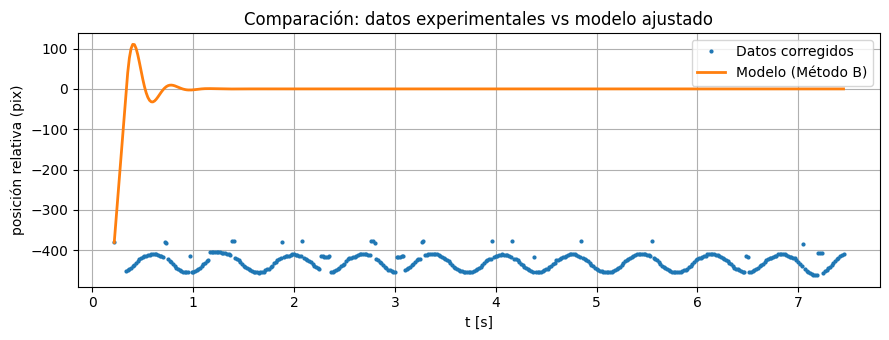

In [101]:
"""
RESULTADOS FINALES Y VISUALIZACIÓN GENERAL
------------------------------------------------------------
Objetivo:
  - Guardar en un archivo JSON los resultados de los tres métodos:
        * Método A — Derivadas
        * Método B — EDO no lineal
        * Método C — Decremento logarítmico
  - Incluir además la información del ROI y del frame de inicio.
  - Graficar la señal experimental junto con la simulación
    del modelo ajustado (Método B) para validación visual.

Entradas:
  - est_M1, est_M2, est_M3 : resultados de los métodos A–C
  - ROI, START : parámetros del análisis
  - OUT_DIR : carpeta de salida

Salidas:
  - Archivo JSON con todos los resultados.
  - Gráfico comparativo entre datos y modelo (ODE).
"""

# -----------------------------------------------
# Guardado de resultados globales
# -----------------------------------------------
results = {
    "Metodo_A_derivadas": est_M1,
    "Metodo_B_ODE": est_M2,
    "Metodo_C_log_decremento": est_M3,
    "ROI": ROI,
    "Frame_inicio": int(START)
}

with open(Path(OUT_DIR) / "results.json", "w", encoding="utf-8") as f:
    json.dump(results, f, ensure_ascii=False, indent=2)

print(f"[OK] Resultados guardados en: {Path(OUT_DIR) / 'results.json'}")

# -----------------------------------------------
# Comparación visual: datos vs modelo ODE
# -----------------------------------------------
y0 = float(y_fix[0])
v0 = float(np.gradient(y_fix, t_fix)[0])
yhat = _simulate_mass_spring(t_fix, y0, v0, MASS, est_M2["k"], est_M2["b"])

plt.figure(figsize=(9, 3.5))
plt.plot(t_fix, y_fix, ".", ms=4, color="tab:blue", label="Datos corregidos")
plt.plot(t_fix, yhat, "-", lw=2, color="tab:orange", label="Modelo (Método B)")
plt.xlabel("t [s]")
plt.ylabel("posición relativa (pix)")
plt.title("Comparación: datos experimentales vs modelo ajustado")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



In [102]:
"""
CONCLUSIONES FINALES
------------------------------------------------------------
Objetivo:
  - Resumir los resultados principales obtenidos con los tres métodos.
  - Guiar la interpretación física del experimento masa-resorte.

Puntos de análisis:
  - Calidad de la señal: verificar ruido y consistencia del ROI.
  - Método 1: estimación rápida (k, b) por derivadas → revisar MSE_ydd.
  - Método 2: ajuste ODE → validar R² y coherencia de fase/amplitud.
  - Método 3: zeta, T, omega_d → coherencia con k/m y b/m.
  - Calibrar escala px→cm para expresar parámetros en unidades físicas.
"""

print("=== CONCLUSIONES (BORRADOR) ===\n")

print("→ Detección automática:")
print(f"  ROI seleccionado: {ROI}")
print(f"  Frame inicial: {START}\n")

print("→ Método 1 — Derivadas:")
print(f"  k = {est_M1['k']:.4g}")
print(f"  b = {est_M1['b']:.4g}")
print(f"  MSE(y'') = {est_M1['mse_ydd']:.3g}\n")

print("→ Método 2 — Ajuste de EDO:")
print(f"  k = {est_M2['k']:.4g}")
print(f"  b = {est_M2['b']:.4g}")
print(f"  R² = {est_M2['r2']:.4f}\n")

print("→ Método 3 — Decremento logarítmico:")
print(f"  δ (delta) = {est_M3['delta']:.4g}")
print(f"  ζ (zeta) = {est_M3['zeta']:.4g}")
print(f"  T = {est_M3['T']:.4g} s")
print(f"  ω_d = {est_M3['omega_d']:.4g} rad/s\n")




=== CONCLUSIONES (BORRADOR) ===

→ Detección automática:
  ROI seleccionado: (0, 252, 281, 551)
  Frame inicial: 12

→ Método 1 — Derivadas:
  k = 7.709
  b = 0.02286
  MSE(y'') = 2.43

→ Método 2 — Ajuste de EDO:
  k = 65.93
  b = 2.652
  R² = 0.0282

→ Método 3 — Decremento logarítmico:
  δ (delta) = -0.000394
  ζ (zeta) = -6.271e-05
  T = 0.6749 s
  ω_d = 9.31 rad/s

